### instalations needed:  
torch, transformers, evaluate

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizerFast, AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification, get_scheduler
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import pandas as pd

# Fineturning the  DAPT  NER model 

### INPUT:
 
 #### NER model with domain adaptive pretraining
- ner_DAPT_model 


#### English Web Treebank training set 
- en_ewt-ud-train.iob2  

if you downloaded the repository, you can find the files there:    
/NLP-spring-2025/datasets_orginal    
  
  
#### training dataset for finetuning   (one of):

- rap-hip-hop-manual-1000-train.iob2   
- pop-manual-1000-train.iob2   
- country-manual-1000-train.iob2   
- 3genres_.iob2   
 
if you downloaded the repository, you can find the files there:  
/NLP-spring-2025/'GENRE'/ datasets  
  
 ### OUTPUT:
 #### Finetuned new model (one of):

- ner_DAPT_model_finetuned_on_3genres   
- ner_DAPT_model_finetuned_on_rap-hip-hop   
- ner_DAPT_model_finetuned_on_pop   
- ner_DAPT_model_finetuned_on_country   
  
recomended path:  
/NLP-spring-2025/'GENRE'

In [11]:
# ------------------------------------------------------------------------------------------------------
BASE_MODEL_PATH = "/path/ner_DAPT_model"                         # path to DAPT NER model 
NEW_TRAIN_FILE = "/path/pop-manual-1000-train.iob2"              # path to training dataset 
OUTPUT_MODEL_PATH = "/path/ner_DAPT_model_finetuned_on_pop"      # path to output model  ( DOMAIN SPECIFIC FINETUNING)
# ------------------------------------------------------------------------------------------------------

epochs = 5
train_batch_size = 16
learning_rate = 5e-6  
max_len = 128


#load tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained(BASE_MODEL_PATH, add_prefix_space=True, use_fast=True)

#reuse label mappings from EWT
def get_label_mappings(file_path):
    label_set = set()
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith('#'):
                parts = line.split('\t')
                if len(parts) > 2:
                    label_set.add(parts[2])
    tag2idx = {label: idx for idx, label in enumerate(sorted(label_set))}
    idx2tag = {idx: label for label, idx in tag2idx.items()}
    return tag2idx, idx2tag

# ------------------------------------------------------------------------------------------------------
tag2idx, idx2tag = get_label_mappings("/path/en_ewt-ud-train.iob2")  #path to ewt training data
# ------------------------------------------------------------------------------------------------------

class NERDataset(Dataset):
    def __init__(self, file_path, tokenizer, tag2idx, max_len=128):
        self.sentences, self.labels = self.load_data(file_path)
        self.tokenizer = tokenizer
        self.tag2idx = tag2idx
        self.max_len = max_len

    def load_data(self, file_path):
        sentences, labels = [], []
        sentence, label = [], []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    if not line.startswith('#'):
                        parts = line.split('\t')
                        if len(parts) > 2:
                            sentence.append(parts[1])
                            label.append(parts[2])
                else:
                    if sentence:
                        sentences.append(sentence)
                        labels.append(label)
                        sentence, label = [], []
        if sentence:
            sentences.append(sentence)
            labels.append(label)
        return sentences, labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        tags = self.labels[idx]
        tag_ids = [self.tag2idx[tag] for tag in tags]

        encodings = self.tokenizer(words, is_split_into_words=True, truncation=True, max_length=self.max_len, padding=False)
        word_ids = encodings.word_ids()

        aligned_labels = [-100] * len(word_ids)
        prev_word_id = None
        for i, word_id in enumerate(word_ids):
            if word_id is None:
                aligned_labels[i] = -100
            elif word_id != prev_word_id:
                aligned_labels[i] = tag_ids[word_id]
            else:
                aligned_labels[i] = -100
            prev_word_id = word_id

        return {
            'input_ids': torch.tensor(encodings['input_ids']),
            'attention_mask': torch.tensor(encodings['attention_mask']),
            'labels': torch.tensor(aligned_labels)
        }

#load training dataset
lyrics_dataset = NERDataset(NEW_TRAIN_FILE, tokenizer, tag2idx)
lyrics_loader = DataLoader(lyrics_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=DataCollatorForTokenClassification(tokenizer))

#load model
config = AutoConfig.from_pretrained(BASE_MODEL_PATH, num_labels=len(tag2idx), id2label=idx2tag, label2id=tag2idx)
model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_PATH, config=config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_training_steps = len(lyrics_loader) * epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0.1*num_training_steps, num_training_steps=num_training_steps)

scaler = GradScaler()

#fine-tuning
print("Starting fine-tuning")
model.train()
train_losses = []

for epoch in range(epochs):
    total_loss = 0
    progress_bar = tqdm(lyrics_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        with autocast():
            outputs = model(**batch)
            loss = outputs.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        lr_scheduler.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(lyrics_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} completed. Average loss: {avg_loss:.4f}")

#save the new fine-tuned model
os.makedirs(OUTPUT_MODEL_PATH, exist_ok=True)
model.save_pretrained(OUTPUT_MODEL_PATH)
tokenizer.save_pretrained(OUTPUT_MODEL_PATH)
print(f"New fine-tuned model saved to {OUTPUT_MODEL_PATH}")

/tmp/ipykernel_504/1376905227.py:115: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Starting fine-tuning on new lyrics...


Epoch 1/5:   0%|          | 0/188 [00:00<?, ?it/s]/tmp/ipykernel_504/1376905227.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/5: 100%|██████████| 188/188 [01:26<00:00,  2.16it/s]


Epoch 1 completed. Average loss: 0.1387


Epoch 2/5: 100%|██████████| 188/188 [01:25<00:00,  2.21it/s]


Epoch 2 completed. Average loss: 0.0924


Epoch 3/5: 100%|██████████| 188/188 [01:24<00:00,  2.22it/s]


Epoch 3 completed. Average loss: 0.0756


Epoch 4/5: 100%|██████████| 188/188 [01:23<00:00,  2.25it/s]


Epoch 4 completed. Average loss: 0.0691


Epoch 5/5: 100%|██████████| 188/188 [01:22<00:00,  2.27it/s]


Epoch 5 completed. Average loss: 0.0606
New fine-tuned model saved to /work/project/ner_model_finetuned_on_3genres


# Generating pseudo-labels on unlabeled data using a previously fine-tuned model, as part of a self-training pipeline.

## CODE 1 (for single genre)
### INPUT:
#### ner_DAPT_model finetuned  (one of):  

- ner_DAPT_model_finetuned_on_rap-hip-hop     
- ner_DAPT_model_finetuned_on_pop     
- ner_DAPT_model_finetuned_on_country   
  
if you follow the recomended paths:  
/NLP-spring-2025/'GENRE' 
    
#### dataset for generating more training datasets  (one of):

- rap-hip-hop_labeled_no_2000_all_O.iob2  
- pop_labeled_no_2000_all_O.iob2  
- country_labeled_no_2000_all_O.iob2  

if you downloaded the repository, you can find the files there:    
/NLP-spring-2025/'GENRE'/datasets  
  
### OUTPUT:
#### new training dataset (one of):  
 

- rap-hip-hop_labeled_no_2000.iob2
- pop_labeled_no_2000.iob2
- country_labeled_no_2000.iob2

recomended path:  
/NLP-spring-2025/'GENRE'/datasets 
 
-----------------------------------------------------------------------------------------------------------------

## CODE 2 (3 genres combined) 
### INPUT:
#### ner_DAPT_model finetuned :

- ner_DAPT_model_finetuned_on_3genres 
  
if you follow the recomended paths:    
/NLP-spring-2025/3genres   
    
####  training datasetsfor generating more training datasets  (all): 

- rap-hip-hop_labeled_no_2000_all_O.iob2  
- pop_labeled_no_2000_all_O.iob2  
- country_labeled_no_2000_all_O.iob2  

if you downloaded the repository, you can find the files there:      
/NLP-spring-2025/'GENRE'/datasets  
 
### OUTPUT:
#### new training dataset:

- merged_3genres_labeled.iob2
 
recomended path:    
/NLP-spring-2025/3genres/datasets  

In [ ]:
#------------------------------------------------------------------------------------------
#
#
#                                            CODE 1 
#
#
#------------------------------------------------------------------------------------------

#------------------------------------------------------------------------------------------

MODEL_PATH = "/path/ner_DAPT_model_finetuned_on_pop"   #path to finetuned model 

#------------------------------------------------------------------------------------------


tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_PATH, add_prefix_space=True, use_fast=True)
model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

#Label mappings 
tag2idx = model.config.label2id
idx2tag = model.config.id2label


class NERDataset(Dataset):
    def __init__(self, file_path, tokenizer, tag2idx, max_len=128):
        self.sentences, self.labels, self.raw_data = self.load_data(file_path)
        self.tokenizer = tokenizer
        self.tag2idx = tag2idx
        self.max_len = max_len

    def load_data(self, file_path):
        sentences, labels, raw_data = [], [], []
        sentence, label, sentence_data = [], [], []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    sentence_data.append(line)
                    if line.startswith('#'):
                        continue
                    parts = line.split('\t')
                    if len(parts) > 2:
                        sentence.append(parts[1])
                        label.append(parts[2])
                else:
                    if sentence:
                        sentences.append(sentence)
                        labels.append(label)
                        raw_data.append(sentence_data)
                    sentence, label, sentence_data = [], [], []
        if sentence:
            sentences.append(sentence)
            labels.append(label)
            raw_data.append(sentence_data)
        return sentences, labels, raw_data

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        tags = self.labels[idx]
        tag_ids = [self.tag2idx.get(tag, 0) for tag in tags]
        encodings = self.tokenizer(
            words, is_split_into_words=True, truncation=True,
            max_length=self.max_len, padding=False
        )
        word_ids = encodings.word_ids()
        aligned_labels = [-100] * len(word_ids)
        prev_word_id = None
        for i, word_id in enumerate(word_ids):
            if word_id is None:
                aligned_labels[i] = -100
            elif word_id != prev_word_id:
                aligned_labels[i] = tag_ids[word_id]
            else:
                aligned_labels[i] = -100
            prev_word_id = word_id
        return {
            'input_ids': torch.tensor(encodings['input_ids']),
            'attention_mask': torch.tensor(encodings['attention_mask']),
            'labels': torch.tensor(aligned_labels)
        }

#prediction function
def write_predictions(model, dataset, dataloader, output_path):
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            for i in range(len(predictions)):
                pred_tags = []
                for j, pred in enumerate(predictions[i]):
                    if labels[i][j] != -100:
                        pred_tags.append(idx2tag[pred.item()])
                all_predictions.append(pred_tags)

    with open(output_path, "w", encoding="utf-8") as f:
        pred_idx = 0
        for data in dataset.raw_data:
            sent_counter = 0
            for line in data:
                if line.startswith('#'):
                    f.write(f"{line}\n")
                    continue
                if line:
                    parts = line.split('\t')
                    if len(parts) > 2:
                        tag = all_predictions[pred_idx][sent_counter] if sent_counter < len(all_predictions[pred_idx]) else "O"
                        f.write(f"{parts[0]}\t{parts[1]}\t{tag}\t-\t-\n")
                        sent_counter += 1
            f.write("\n")
            pred_idx += 1
    print(f"Predictions written to {output_path}")


    
#------------------------------------------------------------------------------------------

test_file = "/path/pop_labeled_no_2000_all_O.iob2"  #path to not labeled training file
output_file = "/path/pop_labeled_no_2000.iob2"      #path to output file (new training file)

#------------------------------------------------------------------------------------------


test_dataset = NERDataset(test_file, tokenizer, tag2idx)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=DataCollatorForTokenClassification(tokenizer))

write_predictions(model, test_dataset, test_loader, output_file)


In [13]:
#------------------------------------------------------------------------------------------
#
#
#                                            CODE 2 
#
#
#------------------------------------------------------------------------------------------

#------------------------------------------------------------------------------------------

MODEL_PATH = "/work/project/ner_model_finetuned_on_3genres"   #path to finetuned model 

#------------------------------------------------------------------------------------------

tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_PATH, add_prefix_space=True, use_fast=True)
model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

#label mappings
tag2idx = model.config.label2id
idx2tag = model.config.id2label


class NERDataset(Dataset):
    def __init__(self, file_path, tokenizer, tag2idx, max_len=128):
        self.sentences, self.labels, self.raw_data = self.load_data(file_path)
        self.tokenizer = tokenizer
        self.tag2idx = tag2idx
        self.max_len = max_len

    def load_data(self, file_path):
        sentences, labels, raw_data = [], [], []
        sentence, label, sentence_data = [], [], []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    sentence_data.append(line)
                    if line.startswith('#'):
                        continue
                    parts = line.split('\t')
                    if len(parts) > 2:
                        sentence.append(parts[1])
                        label.append(parts[2])
                else:
                    if sentence:
                        sentences.append(sentence)
                        labels.append(label)
                        raw_data.append(sentence_data)
                    sentence, label, sentence_data = [], [], []
        if sentence:
            sentences.append(sentence)
            labels.append(label)
            raw_data.append(sentence_data)
        return sentences, labels, raw_data

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        tags = self.labels[idx]
        tag_ids = [self.tag2idx.get(tag, 0) for tag in tags]
        encodings = self.tokenizer(
            words, is_split_into_words=True, truncation=True,
            max_length=self.max_len, padding=False
        )
        word_ids = encodings.word_ids()
        aligned_labels = [-100] * len(word_ids)
        prev_word_id = None
        for i, word_id in enumerate(word_ids):
            if word_id is None:
                aligned_labels[i] = -100
            elif word_id != prev_word_id:
                aligned_labels[i] = tag_ids[word_id]
            else:
                aligned_labels[i] = -100
            prev_word_id = word_id
        return {
            'input_ids': torch.tensor(encodings['input_ids']),
            'attention_mask': torch.tensor(encodings['attention_mask']),
            'labels': torch.tensor(aligned_labels)
        }

#prediction function
def write_predictions(model, dataset, dataloader, output_path):
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            for i in range(len(predictions)):
                pred_tags = []
                for j, pred in enumerate(predictions[i]):
                    if labels[i][j] != -100:
                        pred_tags.append(idx2tag[pred.item()])
                all_predictions.append(pred_tags)

    with open(output_path, "w", encoding="utf-8") as f:
        pred_idx = 0
        for data in dataset.raw_data:
            sent_counter = 0
            for line in data:
                if line.startswith('#'):
                    f.write(f"{line}\n")
                    continue
                if line:
                    parts = line.split('\t')
                    if len(parts) > 2:
                        tag = all_predictions[pred_idx][sent_counter] if sent_counter < len(all_predictions[pred_idx]) else "O"
                        f.write(f"{parts[0]}\t{parts[1]}\t{tag}\t-\t-\n")
                        sent_counter += 1
            f.write("\n")
            pred_idx += 1
    print(f"Predictions written to {output_path}")


#------------------------------------------------------------------------------------------

test_files = [
    "/path/pop_labeled_no_2000_all_O.iob2",  
    "path/country_labeled_no_2000_all_O.iob2",
    "/path/rap-hip-hop/rap-hip-hop_labeled_no_2000_all_O.iob2"     #path to all not labeled training files
]


output_file = "/path/merged_3genres_labeled.iob2"              #path to output file (new training file)

#------------------------------------------------------------------------------------------

with open(output_file, "w", encoding="utf-8") as fout:
    for test_file in test_files:
        print(f" Processing {test_file}")

        #load test dataset
        test_dataset = NERDataset(test_file, tokenizer, tag2idx)
        test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=DataCollatorForTokenClassification(tokenizer))

        #predict
        model.eval()
        all_predictions = []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f"Predicting {os.path.basename(test_file)}"):
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                predictions = outputs.logits.argmax(dim=-1).cpu().numpy()
                labels = batch["labels"].cpu().numpy()

                for i in range(len(predictions)):
                    pred_tags = []
                    for j, pred in enumerate(predictions[i]):
                        if labels[i][j] != -100:
                            pred_tags.append(idx2tag[pred.item()])
                    all_predictions.append(pred_tags)

        #write predictions
        pred_idx = 0
        for data in test_dataset.raw_data:
            sent_counter = 0
            for line in data:
                if line.startswith('#'):
                    fout.write(f"{line}\n")
                    continue
                if line:
                    parts = line.split('\t')
                    if len(parts) > 2:
                        tag = all_predictions[pred_idx][sent_counter] if sent_counter < len(all_predictions[pred_idx]) else "O"
                        fout.write(f"{parts[0]}\t{parts[1]}\t{tag}\t-\t-\n")
                        sent_counter += 1
            fout.write("\n")
            pred_idx += 1

print(f" All predictions written to: {output_file}")


🔍 Processing /work/project/pop/pop_labeled_no_2000_all_O.iob2


Predicting pop_labeled_no_2000_all_O.iob2: 100%|██████████| 1036/1036 [01:58<00:00,  8.76it/s]


🔍 Processing /work/project/country/country_labeled_no_2000_all_O.iob2


Predicting country_labeled_no_2000_all_O.iob2: 100%|██████████| 576/576 [01:02<00:00,  9.23it/s]


🔍 Processing /work/project/rap-hip-hop/rap-hip-hop_labeled_no_2000_all_O.iob2


Predicting rap-hip-hop_labeled_no_2000_all_O.iob2: 100%|██████████| 1599/1599 [03:14<00:00,  8.24it/s]


✅ All predictions written to: /work/project/merged_3genres_predictions.iob2


# Continual Learning (Self-Training)

### INPUT:
#### ner_DAPT_model finetuned  (one of):      
  
- ner_DAPT_model_finetuned_on_rap-hip-hop     
- ner_DAPT_model_finetuned_on_pop     
- ner_DAPT_model_finetuned_on_country     
- ner_DAPT_model_finetuned_on_3genres  
  
if you follow the recomended paths:      
/NLP-spring-2025/'GENRE'

#### training dataset for continuous learning (one of):  

- rap-hip-hop_labeled_no_2000.iob2
- pop_labeled_no_2000.iob2
- country_labeled_no_2000.iob2
- merged_3genres_labeled.iob2  
  
if you follow the recomended paths:         
/NLP-spring-2025/'GENRE'/datasets 


#### English Web Treebank training set 
- en_ewt-ud-train.iob2  
  
if you downloaded the repository, you can find the files there:  
/NLP-spring-2025/datasets_orginal   
  
### OUTPUT:
#### new ner DAPT model - after continuous learning (one of):  

- ner_DAPT_model_cont_on_rap-hip-hop
- ner_DAPT_model_cont_on_pop
- ner_DAPT_model_cont_on_country
- ner_DAPT_model_cont_on_3genres  
  
recomended path:    
/NLP-spring-2025/'GENRE' 

In [18]:
#------------------------------------------------------------------------------------------

BASE_MODEL_PATH = "/path/ner_DAPT_model_finetuned_on_pop"         # path to DAPT NER model
NEW_TRAIN_FILE = "/path/pop_labeled_no_2000.iob2"            #path to new training dataset
OUTPUT_MODEL_PATH = "/path/ner_DAPT_model_cont_on_pop"       #new model (CONTINUOUS LEARNING)

#------------------------------------------------------------------------------------------
epochs = 3
train_batch_size = 64
learning_rate = 5e-6  
max_len = 128



tokenizer = RobertaTokenizerFast.from_pretrained(BASE_MODEL_PATH, add_prefix_space=True, use_fast=True)

#reuse label mappings from EWT 
def get_label_mappings(file_path):
    label_set = set()
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith('#'):
                parts = line.split('\t')
                if len(parts) > 2:
                    label_set.add(parts[2])
    tag2idx = {label: idx for idx, label in enumerate(sorted(label_set))}
    idx2tag = {idx: label for label, idx in tag2idx.items()}
    return tag2idx, idx2tag

#------------------------------------------------------------------------------------------

tag2idx, idx2tag = get_label_mappings("/path/en_ewt-ud-train.iob2") #path to ewt training data

#------------------------------------------------------------------------------------------
# Dataset class
class NERDataset(Dataset):
    def __init__(self, file_path, tokenizer, tag2idx, max_len=128):
        self.sentences, self.labels = self.load_data(file_path)
        self.tokenizer = tokenizer
        self.tag2idx = tag2idx
        self.max_len = max_len

    def load_data(self, file_path):
        sentences, labels = [], []
        sentence, label = [], []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    if not line.startswith('#'):
                        parts = line.split('\t')
                        if len(parts) > 2:
                            sentence.append(parts[1])
                            label.append(parts[2])
                else:
                    if sentence:
                        sentences.append(sentence)
                        labels.append(label)
                        sentence, label = [], []
        if sentence:
            sentences.append(sentence)
            labels.append(label)
        return sentences, labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        tags = self.labels[idx]
        tag_ids = [self.tag2idx[tag] for tag in tags]

        encodings = self.tokenizer(words, is_split_into_words=True, truncation=True, max_length=self.max_len, padding=False)
        word_ids = encodings.word_ids()

        aligned_labels = [-100] * len(word_ids)
        prev_word_id = None
        for i, word_id in enumerate(word_ids):
            if word_id is None:
                aligned_labels[i] = -100
            elif word_id != prev_word_id:
                aligned_labels[i] = tag_ids[word_id]
            else:
                aligned_labels[i] = -100
            prev_word_id = word_id

        return {
            'input_ids': torch.tensor(encodings['input_ids']),
            'attention_mask': torch.tensor(encodings['attention_mask']),
            'labels': torch.tensor(aligned_labels)
        }

#load new dataset
lyrics_dataset = NERDataset(NEW_TRAIN_FILE, tokenizer, tag2idx)
lyrics_loader = DataLoader(lyrics_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=DataCollatorForTokenClassification(tokenizer))

#load model
config = AutoConfig.from_pretrained(BASE_MODEL_PATH, num_labels=len(tag2idx), id2label=idx2tag, label2id=tag2idx)
model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_PATH, config=config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_training_steps = len(lyrics_loader) * epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0.1*num_training_steps, num_training_steps=num_training_steps)

scaler = GradScaler()

#continuous learning
print("Starting continuous learning:")
model.train()
train_losses = []

for epoch in range(epochs):
    total_loss = 0
    progress_bar = tqdm(lyrics_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        with autocast():
            outputs = model(**batch)
            loss = outputs.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        lr_scheduler.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(lyrics_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} completed. Average loss: {avg_loss:.4f}")

#save the new model after continuous learning
os.makedirs(OUTPUT_MODEL_PATH, exist_ok=True)
model.save_pretrained(OUTPUT_MODEL_PATH)
tokenizer.save_pretrained(OUTPUT_MODEL_PATH)
print(f"New model (after continuous learning) saved to {OUTPUT_MODEL_PATH}")


/tmp/ipykernel_504/2446819092.py:115: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Starting fine-tuning on new lyrics...


Epoch 1/3:   0%|          | 0/1605 [00:00<?, ?it/s]/tmp/ipykernel_504/2446819092.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/3: 100%|██████████| 1605/1605 [35:47<00:00,  1.34s/it]


Epoch 1 completed. Average loss: 0.0094


Epoch 2/3: 100%|██████████| 1605/1605 [35:54<00:00,  1.34s/it]


Epoch 2 completed. Average loss: 0.0071


Epoch 3/3: 100%|██████████| 1605/1605 [35:40<00:00,  1.33s/it]


Epoch 3 completed. Average loss: 0.0056
New fine-tuned model saved to /work/project/ner_model_DOUBLE_finetuned_on_3genres


# predictions

### INPUT:
#### ner_DAPT_model path (one of):  
- ner_DAPT_model_finetuned_on_rap-hip-hop     
- ner_DAPT_model_finetuned_on_pop     
- ner_DAPT_model_finetuned_on_country     
- ner_DAPT_model_finetuned_on_3genres

- ner_DAPT_model_cont_on_rap-hip-hop
- ner_DAPT_model_cont_on_pop
- ner_DAPT_model_cont_on_country
- ner_DAPT_model_cont_on_3genres  
    
if you follow the recomended paths:  
/NLP-spring-2025/'GENRE'  

#### training dataset for continuous learning (one of):

- rap-hip-hop_labeled_no_2000.iob2
- pop_labeled_no_2000.iob2
- country_labeled_no_2000.iob2
- merged_3genres_labeled.iob2  
  
if you follow the recomended paths:  
/NLP-spring-2025/'GENRE'/datasets    
  
### OUTPUT:
#### prediction file (one of):  
- predictions_rap-hip-hop.iob2
- predictions_pop.iob2
- predictions_country.iob2
- predictions_3genres.iob2

- predictions_continuous_learning_rap-hip-hop.iob2
- predictions_continuous_learning_pop.iob2
- predictions_continuous_learning_country.iob2
- predictions_continuous_learning_3genres.iob2

recomended path:  
/NLP-spring-2025/'GENRE'/predictions

In [ ]:
#------------------------------------------------------------------------------------------

MODEL_PATH = "/path/ner_DAPT_model_finetuned_on_pop"

#------------------------------------------------------------------------------------------
tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_PATH, add_prefix_space=True, use_fast=True)
model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

#label mappings
tag2idx = model.config.label2id
idx2tag = model.config.id2label

class NERDataset(Dataset):
    def __init__(self, file_path, tokenizer, tag2idx, max_len=128):
        self.sentences, self.labels, self.raw_data = self.load_data(file_path)
        self.tokenizer = tokenizer
        self.tag2idx = tag2idx
        self.max_len = max_len

    def load_data(self, file_path):
        sentences, labels, raw_data = [], [], []
        sentence, label, sentence_data = [], [], []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    sentence_data.append(line)
                    if line.startswith('#'):
                        continue
                    parts = line.split('\t')
                    if len(parts) > 2:
                        sentence.append(parts[1])
                        label.append(parts[2])
                else:
                    if sentence:
                        sentences.append(sentence)
                        labels.append(label)
                        raw_data.append(sentence_data)
                    sentence, label, sentence_data = [], [], []
        if sentence:
            sentences.append(sentence)
            labels.append(label)
            raw_data.append(sentence_data)
        return sentences, labels, raw_data

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        tags = self.labels[idx]
        tag_ids = [self.tag2idx.get(tag, 0) for tag in tags]
        encodings = self.tokenizer(
            words, is_split_into_words=True, truncation=True,
            max_length=self.max_len, padding=False
        )
        word_ids = encodings.word_ids()
        aligned_labels = [-100] * len(word_ids)
        prev_word_id = None
        for i, word_id in enumerate(word_ids):
            if word_id is None:
                aligned_labels[i] = -100
            elif word_id != prev_word_id:
                aligned_labels[i] = tag_ids[word_id]
            else:
                aligned_labels[i] = -100
            prev_word_id = word_id
        return {
            'input_ids': torch.tensor(encodings['input_ids']),
            'attention_mask': torch.tensor(encodings['attention_mask']),
            'labels': torch.tensor(aligned_labels)
        }

#prediction function
def write_predictions(model, dataset, dataloader, output_path):
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            for i in range(len(predictions)):
                pred_tags = []
                for j, pred in enumerate(predictions[i]):
                    if labels[i][j] != -100:
                        pred_tags.append(idx2tag[pred.item()])
                all_predictions.append(pred_tags)

    with open(output_path, "w", encoding="utf-8") as f:
        pred_idx = 0
        for data in dataset.raw_data:
            sent_counter = 0
            for line in data:
                if line.startswith('#'):
                    f.write(f"{line}\n")
                    continue
                if line:
                    parts = line.split('\t')
                    if len(parts) > 2:
                        tag = all_predictions[pred_idx][sent_counter] if sent_counter < len(all_predictions[pred_idx]) else "O"
                        f.write(f"{parts[0]}\t{parts[1]}\t{tag}\t-\t-\n")
                        sent_counter += 1
            f.write("\n")
            pred_idx += 1
    print(f"Predictions written to {output_path}")

#run prediction
test_file = "/path/lyrics_test_no_labels.iob2"
output_file = "/path/predictions_pop.iob2"

test_dataset = NERDataset(test_file, tokenizer, tag2idx)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=DataCollatorForTokenClassification(tokenizer))

write_predictions(model, test_dataset, test_loader, output_file)


# Statistics
 #### Input:
 
prediction file (one of):  

   - predictions_rap-hip-hop.iob2

   - predictions_pop.iob2

   - predictions_country.iob2

   - predictions_3genres.iob2

   - predictions_continuous_learning_rap-hip-hop.iob2

   - predictions_continuous_learning_pop.iob2

   - predictions_continuous_learning_country.iob2

   - predictions_continuous_learning_3genres.iob2
   
if you follow the recomended paths:  
/NLP-spring-2025/'GENRE'/predictions  
  
and  
  
   - golden file ( lyrics_test.iob2 )
     
if you downloaded the repository, you can find the files there:  
/NLP-spring-2025/test 




## Mistake breakdown:
#### correct   
Model correctly predicted the label (e.g. B-PER → B-PER)    

#### wrong_label    
Model predicted a named entity, but with the wrong type or boundary (e.g. B-LOC → B-ORG).     
       THIS FOLLOWS UP WITH A DETAILED BREAKDOWN       
  
  
#### spurious    
Model predicted an entity where the gold label was O. These are false positives — overpredictions.  
#### missed    
Model predicted O where the gold label was a named entity. These are false negatives — missed detections.  


In [7]:
def analyze_errors(gold_file, pred_file):
    def read_labels(path):
        sentences = []
        current = []
        with open(path, encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if line == "":
                    if current:
                        sentences.append(current)
                        current = []
                elif line.startswith("#"):
                    continue
                else:
                    current.append(line.split("\t")[2])  # third column
        if current:
            sentences.append(current)
        return sentences

    gold = read_labels(gold_file)
    pred = read_labels(pred_file)

    assert len(gold) == len(pred), "Mismatch in number of sentences"

    counter = Counter()

    for g_sent, p_sent in zip(gold, pred):
        assert len(g_sent) == len(p_sent), "Mismatch in sentence lengths"
        for g, p in zip(g_sent, p_sent):
            if g == p:
                counter["correct"] += 1
            elif g == "O" and p != "O":
                counter["spurious"] += 1
            elif g != "O" and p == "O":
                counter["missed"] += 1
            elif g != p:
                counter[f"{g}->{p}"] += 1
                counter["wrong_label"] += 1

    print("Mistake breakdown:")
    for key, val in counter.most_common():
        print(f"{key:15}: {val}")

#------------------------------------------------------------------------------------------

analyze_errors("lyrics_test.iob2", "predictions_pop.iob2")

#------------------------------------------------------------------------------------------

Mistake breakdown:
correct        : 30260
wrong_label    : 309
spurious       : 304
missed         : 221
B-ORG->B-PER   : 44
I-ORG->I-PER   : 35
B-ORG->B-LOC   : 30
B-PER->I-PER   : 29
I-ORG->I-LOC   : 28
B-PER->B-ORG   : 24
I-PER->B-PER   : 21
B-LOC->B-PER   : 18
B-PER->B-LOC   : 15
I-LOC->B-LOC   : 13
B-LOC->B-ORG   : 13
I-LOC->I-PER   : 10
I-PER->I-ORG   : 10
I-PER->I-LOC   : 7
I-ORG->B-ORG   : 4
B-LOC->I-LOC   : 3
I-ORG->B-PER   : 2
B-PER->I-ORG   : 2
I-LOC->B-PER   : 1


## Confusion matrix of predicted entity labels

- Rows = Gold (true) labels

- Columns = Predicted labels

Each cell counts how often a gold label was predicted as a certain label.

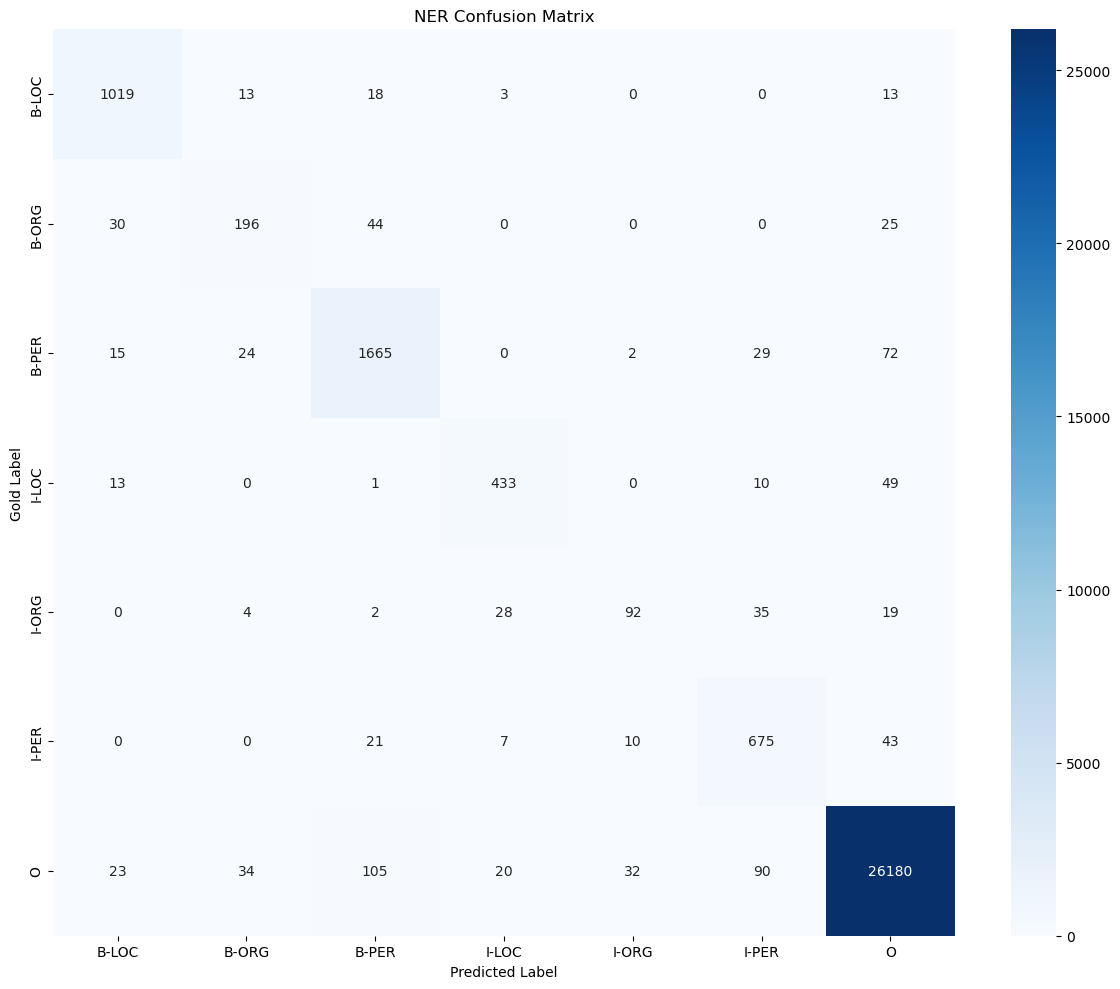

In [8]:
def read_labels(file_path):
    sentences = []
    current = []
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line == "":
                if current:
                    sentences.append(current)
                    current = []
            elif line.startswith("#"):
                continue
            else:
                current.append(line.split("\t")[2])
    if current:
        sentences.append(current)
    return sentences

def create_confusion_matrix(gold_path, pred_path):
    gold_sentences = read_labels(gold_path)
    pred_sentences = read_labels(pred_path)

    assert len(gold_sentences) == len(pred_sentences), "Mismatch in number of sentences"

    all_gold = []
    all_pred = []

    for g_sent, p_sent in zip(gold_sentences, pred_sentences):
        assert len(g_sent) == len(p_sent), "Mismatch in sentence lengths"
        all_gold.extend(g_sent)
        all_pred.extend(p_sent)

    #get all unique labels
    all_labels = sorted(set(all_gold + all_pred))
   
    #build confusion matrix as DataFrame
    confusion = pd.DataFrame(0, index=all_labels, columns=all_labels)

    for g, p in zip(all_gold, all_pred):
        confusion.loc[g, p] += 1

    return confusion

def plot_confusion_matrix(confusion_df, normalize=False, figsize=(12, 10)):
    plt.figure(figsize=figsize)
    data = confusion_df.copy()
    if normalize:
        data = data.div(data.sum(axis=1), axis=0)
    sns.heatmap(data, annot=True, fmt=".2f" if normalize else "d", cmap="Blues")
    plt.title("NER Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.xlabel("Predicted Label")
    plt.ylabel("Gold Label")
    plt.tight_layout()
    plt.show()

#------------------------------------------------------------------------------------------

gold_file = "lyrics_test.iob2"
pred_file = "predictions_pop.iob2"

#------------------------------------------------------------------------------------------

confusion = create_confusion_matrix(gold_file, pred_file)
plot_confusion_matrix(confusion)             
